# Swiss cantons of the 19th century

## Load libraries and functions

In [1]:
# traditional packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# for PCA
from sklearn.decomposition import PCA as skPCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# for hierarchical cluster analysis
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [2]:
# function for making histograms
def myHist(xname, mybins=10):
    pd_x = pd.Series(dfSwiss[xname])

    # histogram
    pd_x.plot.hist(grid=True, bins=mybins, rwidth=0.9, color='lightblue')
    plt.title('Histogram for ' + xname)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [3]:
# function for variances
def varplot(x, label, h=0):
    plt.plot(range(len(x)), x, linestyle="-.")
    plt.title('Plot of '+ label + ' variance')
    plt.xticks(range(len(x)), [y+1 for y in range(len(x))])
    plt.xlabel('Principal components')
    plt.axhline(h)
    plt.grid()
    plt.show()

In [4]:
def biplot(data, pc1loads, pc2loads, pc1, pc2, data_labels=True):

    for i in range(len(pc1loads)):
    # arrows project features as vectors onto PC axes
        plt.arrow(0, 0, pc1loads[i]*max(pc1), pc2loads[i]*max(pc2), color='r')#, width=0.0005, head_width=0.025)
        plt.text(pc1loads[i]*max(pc1)*1.2, pc2loads[i]*max(pc2)*1.2, list(data.columns.values)[i], color='r')

    for i in range(len(pc1)):
    # circles project observations as points onto PC axes
        plt.plot(pc1[i], pc2[i], marker='o', color='blue')
        if data_labels:
            data_label = list(data.index)[i]
        else:
            data_label = ""
        
        plt.text(pc1[i]*1.2, pc2[i]*1.2, data_label, color='blue')
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid()
    plt.show()

## Load and preview the data

In [5]:
# reading the data
dfSwiss = pd.read_excel('SwissCantons.xlsx', sheet_name='data', header=0, index_col=0, na_values=['NA'])

In [6]:
# preview the data frame
dfSwiss.head(6)

,Fertility,Agriculture,Examination,Education,Catholic,InfantMortality
Canton,,,,,,
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6
Porrentruy,76.1,35.3,9,7,90.57,26.6


## 1. Exploratory data analysis

### 1.1. Descriptive statistics

In [7]:
# descriptive statistics
dfSwiss.describe().round(2)

,Fertility,Agriculture,Examination,Education,Catholic,InfantMortality
count,47.00,47.00,47.00,47.00,47.00,47.00
mean,70.14,50.66,16.49,10.98,41.14,19.94
std,12.49,22.71,7.98,9.62,41.70,2.91
min,35.00,1.20,3.00,1.00,2.15,10.80
25%,64.70,35.90,12.00,6.00,5.20,18.15
50%,70.40,54.10,16.00,8.00,15.14,20.00
75%,78.45,67.65,22.00,12.00,93.12,21.70
max,92.50,89.70,37.00,53.00,100.00,26.60


### 1.2. Histograms of the features

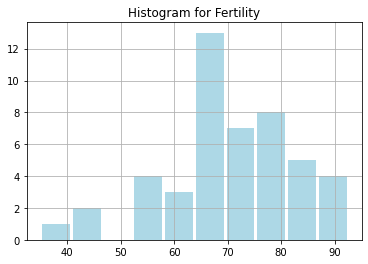

In [8]:
myHist('Fertility')

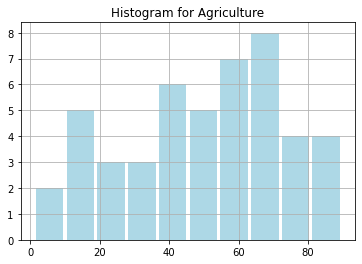

In [9]:
myHist('Agriculture')

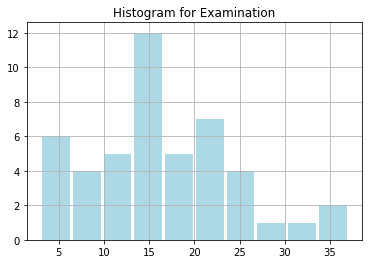

In [10]:
myHist('Examination')

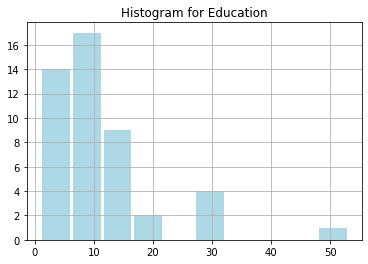

In [11]:
myHist('Education')

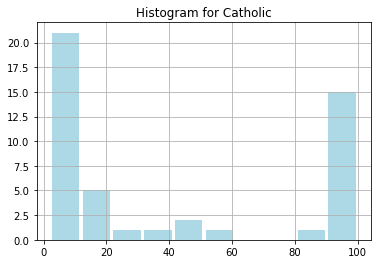

In [12]:
myHist('Catholic')

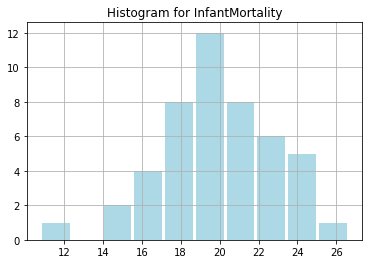

In [13]:
myHist('InfantMortality')

### 1.3. Correlation analysis

In [14]:
# calculate correlations
dfSwiss.corr(method="pearson").round(2)

,Fertility,Agriculture,Examination,Education,Catholic,InfantMortality
Fertility,1.00,0.35,-0.65,-0.66,0.46,0.42
Agriculture,0.35,1.00,-0.69,-0.64,0.40,-0.06
Examination,-0.65,-0.69,1.00,0.70,-0.57,-0.11
Education,-0.66,-0.64,0.70,1.00,-0.15,-0.10
Catholic,0.46,0.40,-0.57,-0.15,1.00,0.18
InfantMortality,0.42,-0.06,-0.11,-0.10,0.18,1.00


## 2. PCA: procedure and results

### 2.1. Data preparation

In [16]:
# scale the data
dfSwissScaled = StandardScaler(with_mean=True, with_std=True).fit_transform(dfSwiss)
dfSwissScaled = pd.DataFrame(dfSwissScaled)

dfSwissScaled.head(5)

,0,1,2,3,4,5
0,0.813835,-1.498091,-0.188705,0.107361,-0.755810,0.783416
1,1.048499,-0.247441,-1.329020,-0.208012,1.059075,0.783416
2,1.809134,-0.487779,-1.455721,-0.628508,1.266546,0.089343
3,1.266979,-0.630202,-0.568810,-0.418260,-0.178721,0.124047
4,0.546803,-0.318652,0.064699,0.422733,-0.872149,0.228158


In [17]:
# re-assign names of rows and columns 
dfSwissScaled.columns = dfSwiss.columns.values
dfSwissScaled.index = dfSwiss.index

dfSwissScaled.head(5)

,Fertility,Agriculture,Examination,Education,Catholic,InfantMortality
Canton,,,,,,
Courtelary,0.813835,-1.498091,-0.188705,0.107361,-0.755810,0.783416
Delemont,1.048499,-0.247441,-1.329020,-0.208012,1.059075,0.783416
Franches-Mnt,1.809134,-0.487779,-1.455721,-0.628508,1.266546,0.089343
Moutier,1.266979,-0.630202,-0.568810,-0.418260,-0.178721,0.124047
Neuveville,0.546803,-0.318652,0.064699,0.422733,-0.872149,0.228158


### 2.2. Run the analysis

In [18]:
# run PCA
pca = skPCA(n_components=None).fit(dfSwissScaled)

**Individual variances**

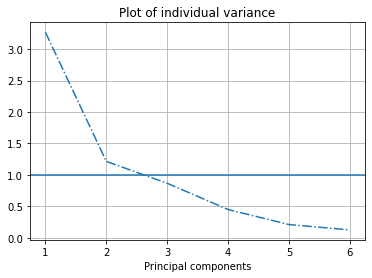

In [19]:
# get the variances of PCs
varExplained=pca.explained_variance_

# h=1 for the Kaiser criterion
varplot(varExplained, "individual", h=1)

**Cumulative variance**

In [20]:
# % of variance explained by PCs
varExplainedRatio = pca.explained_variance_ratio_
varExplainedRatio

array([0.53329283, 0.19805137, 0.1412683 , 0.07315478, 0.03408895,
       0.02014376])

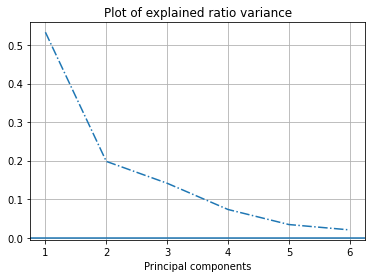

In [21]:
varplot(varExplainedRatio, "explained ratio")

In [22]:
# cumulative variance
cumulVarExplained = np.cumsum(varExplainedRatio)
cumulVarExplained

array([0.53329283, 0.73134421, 0.87261251, 0.94576729, 0.97985624,
       1.        ])

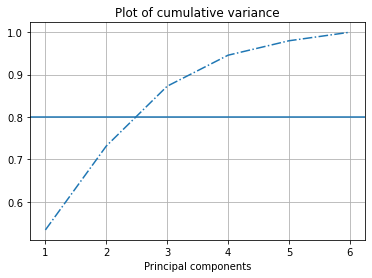

In [23]:
varplot(cumulVarExplained, "cumulative", h=0.8)

## 3. PCA results

### 3.1. PCs: loadings and values

In [24]:
# (!) "components_" means "loadings"
# (!) 0,1 denote PC1 and PC2; change values to get other PCs
PC1loadings = pca.components_[0] 
PC2loadings = pca.components_[1]

# print PC1 loadings
PC1loadings

array([-0.45698761, -0.42421408,  0.50973275,  0.4543119 , -0.35011114,
       -0.14966679])

In [25]:
# the values 
PC1values = pca.transform(dfSwissScaled)[:,0]
PC2values = pca.transform(dfSwissScaled)[:,1]

# make a data-frame of PCs
dfPCs = pd.DataFrame({'PC1': PC1values,
                    'PC2': PC2values})
dfPCs.index = dfSwiss.index

# print PC1 values
dfPCs.tail(10)

,PC1,PC2
Canton,,
Sion,-1.079172,-0.328253
Boudry,1.167838,0.376142
La_Chauxdfnd,1.987548,0.929831
Le_Locle,1.307113,0.414674
Neuchatel,3.082738,1.919769
Val_de_Ruz,-0.011427,0.223313
ValdeTravers,1.355786,0.339548
V_De_Geneve,5.655658,0.563338
Rive_Droite,1.858266,-0.714883


In [26]:
# check that PC values are uncorrelated
dfPCs.corr().round(3)

,PC1,PC2
PC1,1.0,-0.0
PC2,-0.0,1.0


### 3.2. Interpretation of PCs

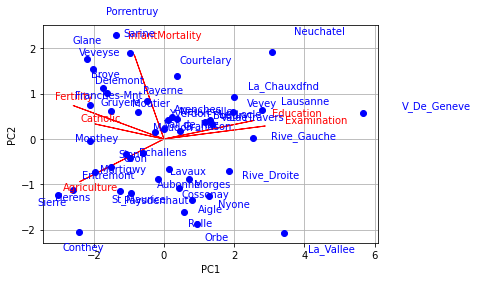

In [33]:
# construct a biplot
biplot(dfSwiss, PC1loadings, PC2loadings, PC1values, PC2values, data_labels=True)

In [28]:
# example of correlation
np.corrcoef(dfPCs['PC1'], dfSwiss['Examination']).round(2)

array([[1.  , 0.91],
       [0.91, 1.  ]])

### 3.3. Adequacy of PCA

In [29]:
# correlation matrix for the original features
dfSwiss.corr(method="pearson").round(2)

,Fertility,Agriculture,Examination,Education,Catholic,InfantMortality
Fertility,1.00,0.35,-0.65,-0.66,0.46,0.42
Agriculture,0.35,1.00,-0.69,-0.64,0.40,-0.06
Examination,-0.65,-0.69,1.00,0.70,-0.57,-0.11
Education,-0.66,-0.64,0.70,1.00,-0.15,-0.10
Catholic,0.46,0.40,-0.57,-0.15,1.00,0.18
InfantMortality,0.42,-0.06,-0.11,-0.10,0.18,1.00


In [30]:
# The Bartlett test
Bchi_square_value, Bp_value = calculate_bartlett_sphericity(dfSwiss)

print(" -= Bartlett's sphericity test =-")
print("Test statistic = ", Bchi_square_value)
print("P-value =", Bp_value)

 -= Bartlett's sphericity test =-
Test statistic =  144.74955241996057
P-value = 2.6512880535026057e-23


In [31]:
# The Kaiser-Meyer-Olkin test
kmo_all, kmo_model = calculate_kmo(dfSwiss)
print(" -= KMO test =-")
kmo_model

 -= KMO test =-


0.6256807250227788

## 4. Agglomerative Hierarchical Cluster Analysis (AHCA)

### 4.1. Run AHCA

In [34]:
# calculate linkages
hca = linkage(dfSwiss, method='ward', metric='euclidean')

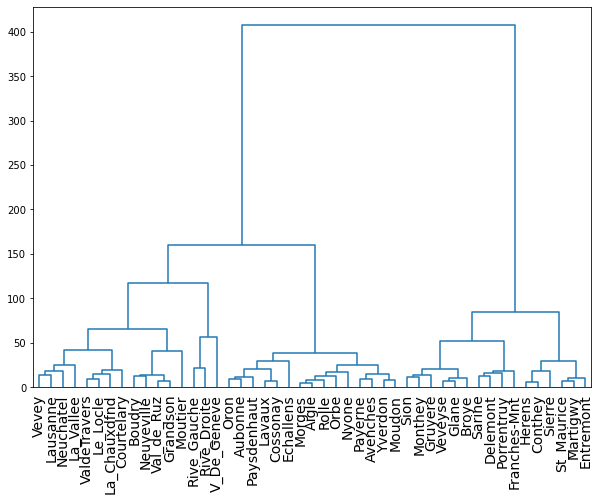

In [35]:
# create a dendrogram
plt.figure(figsize=(10, 7))  


dendrogram(hca, orientation='top',
            labels=dfSwiss.index,
            distance_sort='descending',
            color_threshold=0,
            leaf_font_size=14,leaf_rotation=90,
            show_leaf_counts=True)
plt.show()  

In [36]:
# cut the tree
swissCut = cut_tree(hca, n_clusters=3, height=None)
swissCut


array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [37]:
# look at the results
flattenedSwissCut = [y for x in swissCut for y in x]
print(flattenedSwissCut)

[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 4.2. Interpret the clusters

In [38]:
# extract first cluster
swissHC1 = dfSwiss[swissCut==0]
swissHC1.mean()

Fertility          63.98750
Agriculture        25.28750
Examination        23.12500
Education          18.87500
Catholic           18.57375
InfantMortality    19.54375
dtype: float64

In [39]:
swissHC2 = dfSwiss[swissCut==1]
swissHC2.mean()

Fertility          80.55000
Agriculture        65.51875
Examination         9.43750
Education           6.62500
Catholic           96.15000
InfantMortality    20.77500
dtype: float64

In [40]:
swissHC3 = dfSwiss[swissCut==2]
swissHC3.mean()

Fertility          65.606667
Agriculture        61.873333
Examination        16.933333
Education           7.200000
Catholic            6.545333
InfantMortality    19.480000
dtype: float64

### 4.3. Tandem analysis

In [51]:
colors = []

for i in range(len(flattenedSwissCut)):
    if flattenedSwissCut[i]==0:
        colors.append("hotpink") 
    if flattenedSwissCut[i]==1:
        colors.append("salmon") 
    if flattenedSwissCut[i]==2:
        colors.append("purple") 

In [45]:
colors

['hotpink',
 'green',
 'green',
 'hotpink',
 'hotpink',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'hotpink',
 'hotpink',
 'hotpink',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'hotpink',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'hotpink',
 'hotpink',
 'hotpink',
 'hotpink',
 'hotpink',
 'hotpink',
 'hotpink',
 'hotpink',
 'hotpink']

In [52]:
def coloredBiplot(data, pc1loads, pc2loads, pc1, pc2, data_labels=True):

    for i in range(len(pc1loads)):
    # arrows project features as vectors onto PC axes
        plt.arrow(0, 0, pc1loads[i]*max(pc1), pc2loads[i]*max(pc2), color='r')#, width=0.0005, head_width=0.025)
        plt.text(pc1loads[i]*max(pc1)*1.2, pc2loads[i]*max(pc2)*1.2, list(data.columns.values)[i], color='r')

    for i in range(len(pc1)):
    # circles project observations as points onto PC axes
        plt.plot(pc1[i], pc2[i], marker='o', color=colors[i])
        if data_labels:
            data_label = list(data.index)[i]
        else:
            data_label = ""
        
        plt.text(pc1[i]*1.2, pc2[i]*1.2, data_label, color=colors[i])
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid()
    plt.show()

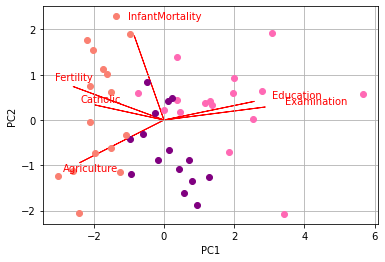

In [54]:
coloredBiplot(dfSwiss, PC1loadings, PC2loadings, PC1values, PC2values, data_labels=False)